Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [266]:
import zipfile
import os
import glob

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import random
from torchvision.utils import make_grid

In [2]:
from tinyVIT import ViT, MAE, CatsDogsDataset


In [3]:
savepath = "mae_trained.pt"

In [4]:
device="cuda"

In [5]:
model = ViT(
        dim = 512,
        image_size = 224,
        patch_size = 16,
        num_classes = 2,
        channels = 3,
        depth = 6,
        heads = 6,
        mlp_dim = 2048,
        dropout = 0.1,
        emb_dropout = 0.1
).to(device)

mae = MAE(
    encoder = model,
    masking_ratio = 0.75,   # the paper recommended 75% masked patches
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
).to(device)

image_height image_width 224
patch_height patch_width 16
patch_dim 768
num_patches 196


In [6]:
checkpoint = torch.load(savepath)
model.load_state_dict(checkpoint['model'])
mae.load_state_dict(checkpoint['mae'])

<All keys matched successfully>

In [7]:
base_dir = "/data2/public_data/dog_v_cat"
train_list = glob.glob(os.path.join(base_dir,"train",'*.jpg'))
test_list = glob.glob(os.path.join(base_dir, "test", '*.jpg'))

In [8]:
test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [9]:
valid_data = CatsDogsDataset(test_list, transform=test_transforms)

In [10]:
valid_loader = DataLoader(dataset=valid_data, batch_size=8, shuffle=False, num_workers=8)

In [11]:
with torch.no_grad():
    for data, label in valid_loader:
        data = data.to(device)
        val_output, mask_indices = mae.predict_pixels(data)
        break

In [12]:
val_output.shape

torch.Size([8, 196, 768])

In [13]:
patch_height = patch_width = 16

In [14]:
val_output.shape

torch.Size([8, 196, 768])

In [589]:
def visualize(model_output, batch_imgs, mask_indices, patch_height=16,patch_width=16):
    unpatched_output = rearrange(model_output, 
                       'b (h w) (p1 p2 c) -> b c (h p1) (w p2)', 
                       p1 = patch_height, 
                       p2 = patch_width, 
                       h = 14, 
                       w = 14)
    
    
    batch_range = torch.arange(batch_imgs.shape[0])[:, None]
    mask = torch.zeros((batch_imgs.shape))
    mask_patch = rearrange(mask, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', h=14,w=14,p1 = patch_height, p2 = patch_width)
    
    mask_patch[batch_range,mask_indices.detach().cpu().numpy()]=1.0
    back_to_mask = rearrange(
        mask_patch, 
        'b (h w) (p1 p2 c) -> b c (w p1) (h p2)', 
        p1 = patch_height, 
        p2 = patch_width, 
        w = 14, 
        h = 14)
    imgs_grid = make_grid(batch_imgs,nrow=4)
    unmpatched_grid = make_grid(unpatched_output,nrow=4)
    mask_grid = make_grid(back_to_mask, nrow=4)

    
    return imgs_grid,unmpatched_grid,mask_grid


In [590]:
from torchvision.transforms.functional import to_pil_image

In [591]:
data.shape

torch.Size([8, 3, 224, 224])

In [592]:
a,b,c=visualize(val_output, data, mask_indices, patch_height=16,patch_width=16)

In [593]:
a.shape

torch.Size([3, 454, 906])

In [594]:
b.shape

torch.Size([3, 454, 906])

In [595]:
c.shape

torch.Size([3, 454, 906])

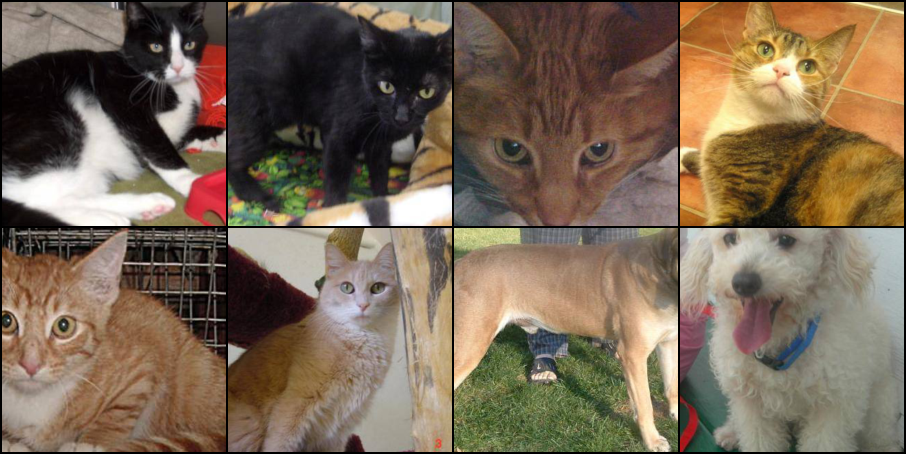

In [596]:
to_pil_image(a)

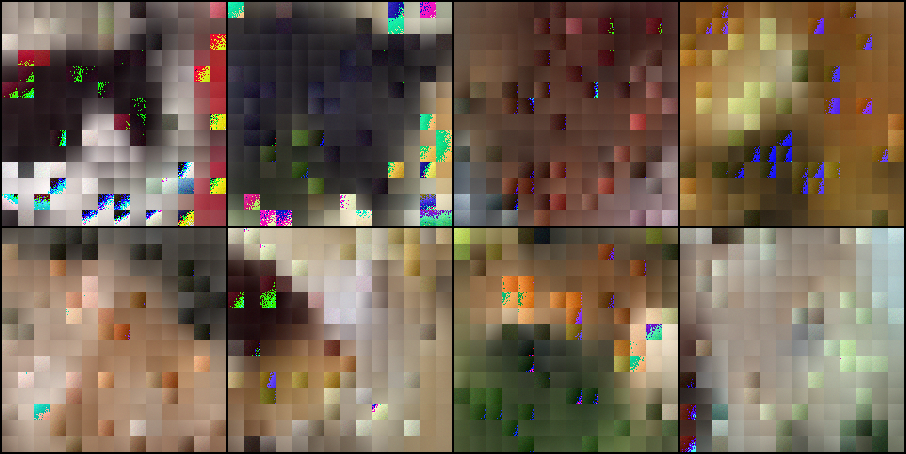

In [597]:
to_pil_image(b)

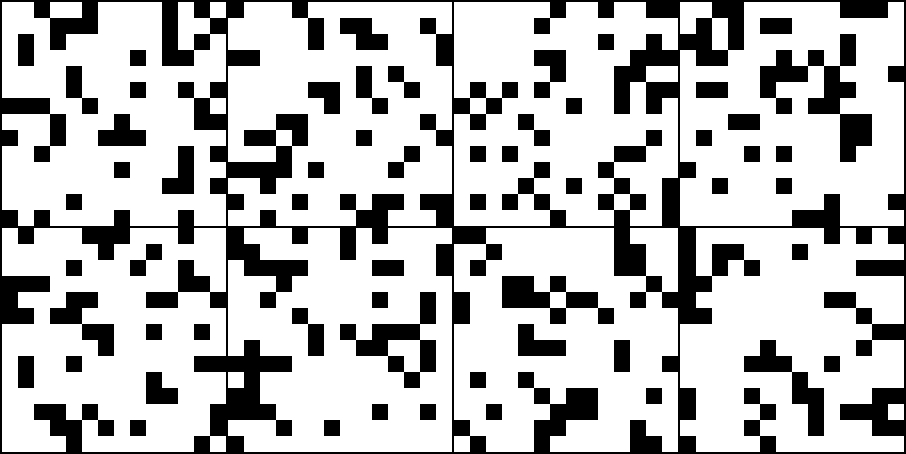

In [598]:
to_pil_image(c)

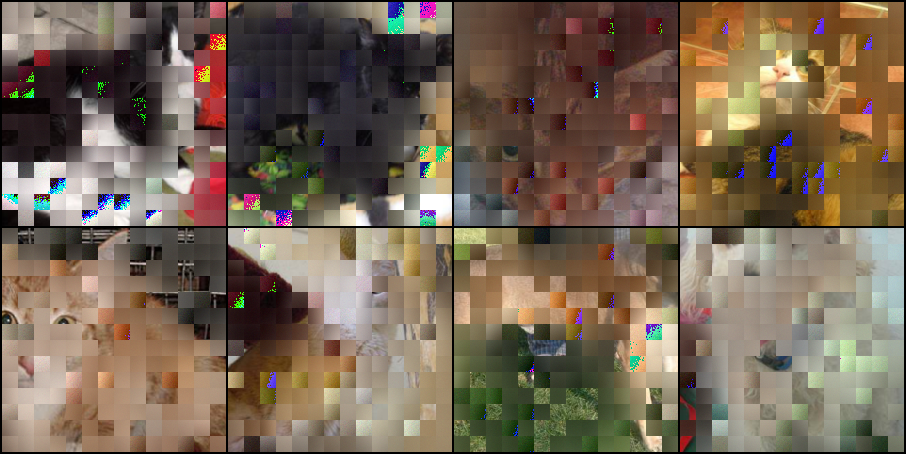

In [601]:
im = Image.composite(to_pil_image(b), to_pil_image(a), to_pil_image(c).convert(mode="L"))
im